In [115]:
#importing the essentials
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

#plotly packages
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#bokeh packages
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure, ColumnDataSource
from bokeh.tile_providers import get_provider, Vendors
from bokeh.palettes import PRGn, RdYlGn
from bokeh.transform import linear_cmap,factor_cmap
from bokeh.layouts import row, column
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter

In [116]:
crime_data = pd.read_csv('crime.csv',encoding='latin')

In [117]:
crime_data = crime_data.fillna('')

In [118]:
crime_data.tail(3)

INCIDENT_NUMBER  OFFENSE_CODE  OFFENSE_CODE_GROUP  \
138548      I172030505          3006  Medical Assistance   
138549      I172030504          1001      Counterfeiting   
138550      I172030502          3201             Propert   

                  OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA SHOOTING  \
138548  SICK/INJURED/MEDICAL - PERSON       C6            914            
138549       FORGERY / COUNTERFEITING       A1            103            
138550                                                                   

           OCCURRED_ON_DATE    YEAR MONTH DAY_OF_WEEK  HOUR    UCR_PART  \
138548  2017-04-19 12:19:00  2017.0   4.0   Wednesday  12.0  Part Three   
138549  2017-04-19 13:35:00  2017.0   4.0   Wednesday  13.0    Part Two   
138550                                                                    

                       STREET        Lat       Long  \
138548  DR. MICHAEL GAVIN WAY  42.326146 -71.053491   
138549              SCHOOL ST  42.357741 -71.059568   
138550                                                

                           Location  
138548  (42.32614559, -71.05349144)  
138549  (42.35774054, -71.05956789)  
138550

In [119]:
crime_data.dtypes

INCIDENT_NUMBER        object
OFFENSE_CODE            int64
OFFENSE_CODE_GROUP     object
OFFENSE_DESCRIPTION    object
DISTRICT               object
REPORTING_AREA         object
SHOOTING               object
OCCURRED_ON_DATE       object
YEAR                   object
MONTH                  object
DAY_OF_WEEK            object
HOUR                   object
UCR_PART               object
STREET                 object
Lat                    object
Long                   object
Location               object
dtype: object

In [120]:
crime_data['Lat'] = pd.to_numeric(crime_data['Lat'],errors = 'coerce')
crime_data['Long'] = pd.to_numeric(crime_data['Long'],errors = 'coerce')
crime_data['MONTH'] = pd.to_numeric(crime_data['MONTH'],errors = 'coerce')

## Analysis

In [25]:
num = crime_data['OFFENSE_CODE_GROUP'].value_counts()
values = num.values
categories = pd.DataFrame(data=num.index, columns=["OFFENSE_CODE_GROUP"])
categories['values'] = values

### Treemap

In [26]:
def treemap(categories,title,path,values):
    fig = px.treemap(categories, path=path, values=values, height=1000,
                 title=title, color_discrete_sequence = px.colors.sequential.RdBu)
    fig.data[0].textinfo = 'label+text+value'
    fig.show()

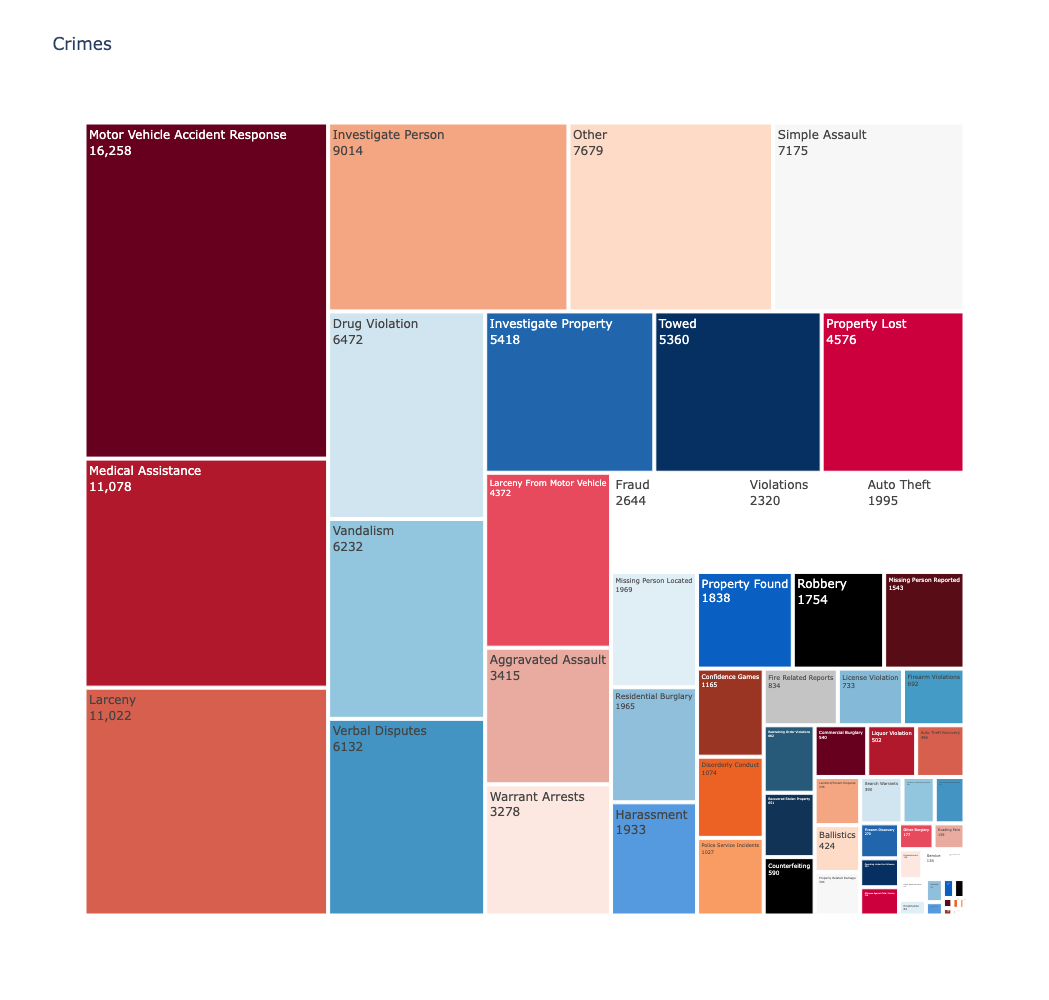

In [27]:
treemap(categories,'Crimes',['OFFENSE_CODE_GROUP'],categories['values'])

### yearly split of crimes using pie chart

In [28]:
num_year = crime_data['YEAR'].value_counts()
years = pd.DataFrame(data=num_year.index, columns=["YEAR"])
years['values'] = num_year.values

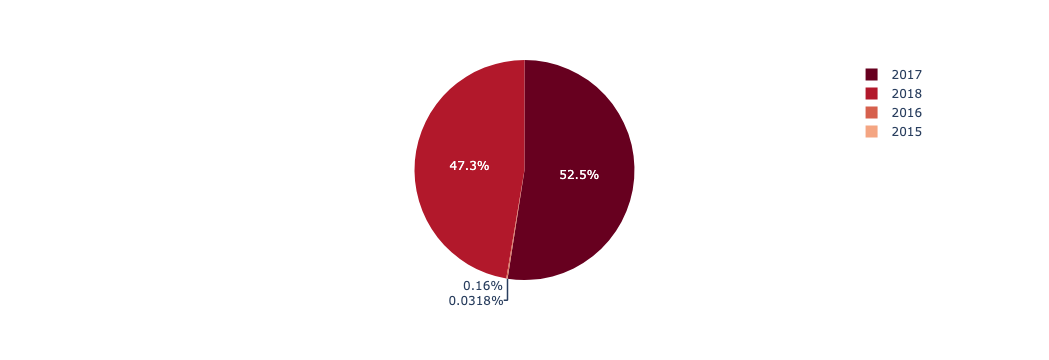

In [29]:
fig = px.pie(years, values='values', names='YEAR', color_discrete_sequence=px.colors.sequential.RdBu)
fig.show()


### Monthly split of crimes using Bar chart

In [30]:
num_month = crime_data['MONTH'].value_counts()
months = pd.DataFrame(data=num_month.index, columns=["MONTH"])
months['values'] = num_month.values

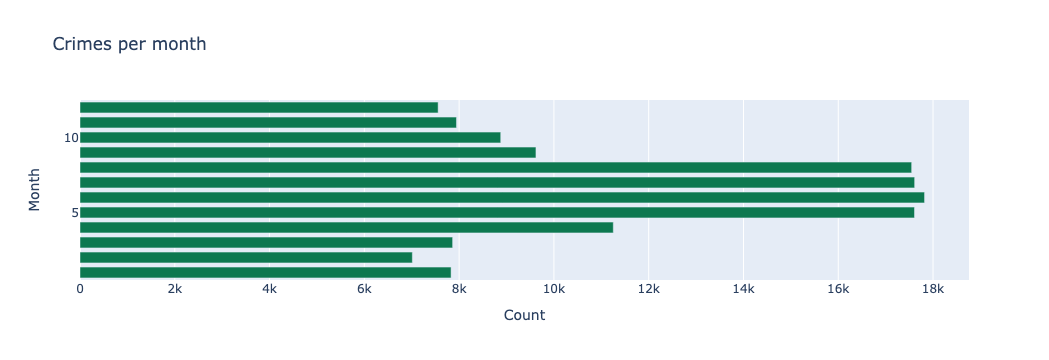

In [31]:
fig = go.Figure(go.Bar(
            x=months['values'],
            y=months['MONTH'],
        marker=dict(
            color='rgb(13,120,80)',

        ),
            orientation='h'))
fig.update_layout(
    title_text='Crimes per month', 
    xaxis_title_text='Count',
    yaxis_title_text='Month', 
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

### Histogram

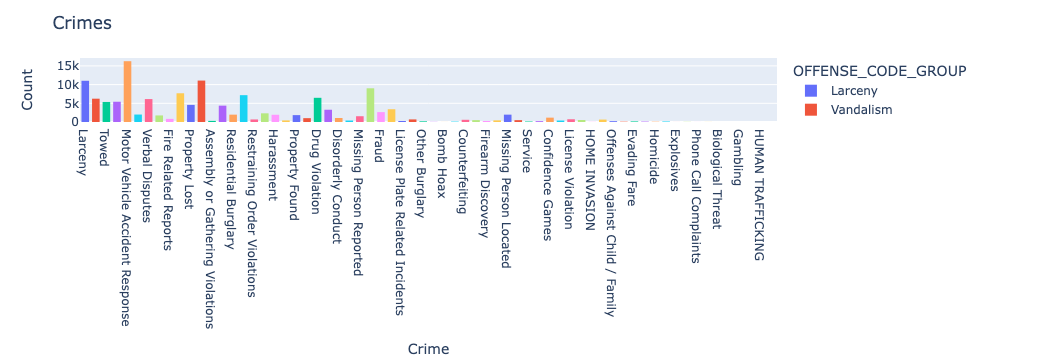

In [32]:
def histogram(data,path,color,title,xaxis,yaxis):
    fig = px.histogram(data, x=path,color=color)
    fig.update_layout(
        title_text=title,
        xaxis_title_text=xaxis, 
        yaxis_title_text=yaxis, 
        bargap=0.2, 
        bargroupgap=0.1
    )
    fig.show()

histogram(crime_data,"OFFENSE_CODE_GROUP","OFFENSE_CODE_GROUP",'Crimes','Crime','Count')

In [57]:
crime_data_2015 = crime_data [(crime_data['YEAR'] == 2015) ].reset_index(drop=True)

In [66]:
crime_data_2015.dtypes

INCIDENT_NUMBER        object
OFFENSE_CODE            int64
OFFENSE_CODE_GROUP     object
OFFENSE_DESCRIPTION    object
DISTRICT               object
REPORTING_AREA         object
SHOOTING               object
OCCURRED_ON_DATE       object
YEAR                   object
MONTH                  object
DAY_OF_WEEK            object
HOUR                   object
UCR_PART               object
STREET                 object
Lat                    object
Long                   object
Location               object
coordinates            object
dtype: object

In [35]:
# # Load the county boundary coordinates
# from urllib.request import urlopen
# import json
# with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
#     counties = json.load(response)

# # Build the choropleth
# import plotly.express as px
# fig = px.choropleth(crime_data_2015, 
#     geojson=counties, 
#     locations='Location', 
#     color='OFFENSE_CODE_GROUP',
#     color_continuous_scale="Viridis",
#     range_color=(0, 12),
#     scope="usa",
# )
# fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

# # Improve the legend
# fig.update_layout(coloraxis_colorbar=dict(
#     thicknessmode="pixels", thickness=10,
#     lenmode="pixels", len=150,
#     yanchor="top", y=0.8,
#     ticks="outside", ticksuffix=" %",
#     dtick=5
# ))

# fig.show()

In [121]:
# Define function to switch from lat/long to mercator coordinates
def x_coord(x, y):
    
    lat = x
    lon = y
    
    r_major = 6378137.000
    x = r_major * np.radians(lon)
    scale = x/lon
    y = 180.0/np.pi * np.log(np.tan(np.pi/4.0 + 
        lat * (np.pi/180.0)/2.0)) * scale
    return (x, y)

# Define coord as tuple (lat,long)
crime_data['coordinates'] = list(zip(crime_data['Lat'], crime_data['Long']))


# Obtain list of mercator coordinates
mercators = [x_coord(x, y) for x, y in crime_data['coordinates'] ]


In [122]:
crime_data.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP      object
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                object
OCCURRED_ON_DATE        object
YEAR                    object
MONTH                  float64
DAY_OF_WEEK             object
HOUR                    object
UCR_PART                object
STREET                  object
Lat                    float64
Long                   float64
Location                object
coordinates             object
dtype: object

In [123]:
# Create mercator column in our df
crime_data['mercator'] = mercators

# Split that column out into two separate cols - mercator_x and mercator_y
crime_data[['mercator_x', 'mercator_y']] = crime_data['mercator'].apply(pd.Series)


# Examine our modified DataFrame
crime_data.head()


INCIDENT_NUMBER  OFFENSE_CODE    OFFENSE_CODE_GROUP   OFFENSE_DESCRIPTION  \
0      I182070945           619               Larceny    LARCENY ALL OTHERS   
1      I182070943          1402             Vandalism             VANDALISM   
2      I182070941          3410                 Towed   TOWED MOTOR VEHICLE   
3      I182070940          3114  Investigate Property  INVESTIGATE PROPERTY   
4      I182070938          3114  Investigate Property  INVESTIGATE PROPERTY   

  DISTRICT REPORTING_AREA SHOOTING     OCCURRED_ON_DATE    YEAR  MONTH  ...  \
0      D14            808           2018-09-02 13:00:00  2018.0    9.0  ...   
1      C11            347           2018-08-21 00:00:00  2018.0    8.0  ...   
2       D4            151           2018-09-03 19:27:00  2018.0    9.0  ...   
3       D4            272           2018-09-03 21:16:00  2018.0    9.0  ...   
4       B3            421           2018-09-03 21:05:00  2018.0    9.0  ...   

   HOUR    UCR_PART       STREET        Lat       Long  \
0  13.0    Part One   LINCOLN ST  42.357791 -71.139371   
1   0.0    Part Two     HECLA ST  42.306821 -71.060300   
2  19.0  Part Three  CAZENOVE ST  42.346589 -71.072429   
3  21.0  Part Three   NEWCOMB ST  42.334182 -71.078664   
4  21.0  Part Three     DELHI ST  42.275365 -71.090361   

                      Location                  coordinates  \
0  (42.35779134, -71.13937053)  (42.35779134, -71.13937053)   
1  (42.30682138, -71.06030035)  (42.30682138, -71.06030035)   
2  (42.34658879, -71.07242943)  (42.34658879, -71.07242943)   
3  (42.33418175, -71.07866441)  (42.33418175, -71.07866441)   
4  (42.27536542, -71.09036101)  (42.27536542, -71.09036101)   

                                  mercator    mercator_x    mercator_y  
0  (-7919198.502753611, 5214726.444926356) -7.919199e+06  5.214726e+06  
1   (-7910396.45057908, 5207051.180814008) -7.910396e+06  5.207051e+06  
2  (-7911746.653588471, 5213038.985905566) -7.911747e+06  5.213039e+06  
3   (-7912440.728387177, 5211170.44342788) -7.912441e+06  5.211170e+06  
4   (-7913742.78794319, 5202317.515073202) -7.913743e+06  5.202318e+06  

[5 rows x 21 columns]

In [127]:
#removed infinite values to remove bokeh error
crime_data = crime_data[~crime_data.isin([np.nan, np.inf, -np.inf]).any(1)]

In [ ]:
# Create map with Bokeh

# Select tile set to use
chosentile = get_provider(Vendors.STAMEN_TONER)

# Choose palette
palette = PRGn[11]

# Tell Bokeh to use df as the source of the data
source = ColumnDataSource(data=crime_data)

# Define color mapper - which column will define the colour of the data points
color_mapper = linear_cmap(field_name = 'MONTH', palette = palette, low = crime_data['MONTH'].min(), high = crime_data['MONTH'].max())




# Create figure
p = figure(title = 'Crime Rates by region in the United States', x_axis_type="mercator", y_axis_type="mercator", 
           x_axis_label = 'Longitude', y_axis_label = 'Latitude')

# Add map tile
p.add_tile(chosentile)

# Add points using mercator coordinates
p.circle(x = 'mercator_x', y = 'mercator_y', color = color_mapper, source=source, size=30, fill_alpha = 0.7)

#Defines color bar
color_bar = ColorBar(color_mapper=color_mapper['transform'], 
                     formatter = NumeralTickFormatter(format='0.0[0000]'), 
                     label_standoff = 13, width=8, location=(0,0))

# Set color_bar location
p.add_layout(color_bar, 'right')

# Display in notebook
output_notebook()

# Save as HTML
output_file('crime.html', title='Crime by region in the United States')

# Show map
show(p)



Loading BokehJS ...